# 1. Colab 환경 설정

####실행에 필요한 라이브러리와 KoBERT 모델을 불러온다

In [1]:
# 1. 코랩 환경 설정
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch
!pip install openpyxl
!pip install kobert_transformers

#Kobert 파일 로드 from github
!pip install git+https://github.com/Jsgithubchannel/KoBERT.git@master

#토큰화
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

     |████████████████████████████████| 47.3 MB 1.4 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 5.1 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595737 sha256=416bd59203f93cbd8908409706732c0a980da1b00f45c30e7ae7fc5a4d2ae9da
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 5.1 MB/s 
     |████████████████████████████████| 3.4 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 51.5 MB/s 
     |████████████████████████████████| 3.3 MB 52.1 MB/s 
     |████████████████████████████████| 895 kB 63.0 MB/s 
     |████████████████████████████████| 61 kB 455 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13


####필요한 모듈을 import

In [2]:
# 환경 설정 (필요한 모듈 import)
import torch
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
import pandas as pd
from tqdm import tqdm, notebook
import openpyxl
import random
import os

#kobert
from kobert.pytorch_kobert import get_pytorch_kobert_model
from kobert_transformers import get_tokenizer, get_kobert_model

#transformers
from transformers import AdamW, BertConfig, BertPreTrainedModel
from transformers.optimization import get_cosine_schedule_with_warmup

####구글 드라이브 연동

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/capstone_design/

Mounted at /content/drive
/content/drive/MyDrive/capstone_design


# 2. 데이터셋 전처리

####구글 드라이브에서 데이터 파일 읽어오기

In [4]:
test_data = pd.read_excel('웰니스_대화_스크립트_데이터셋.xlsx')

In [5]:
test_data

,구분,유저,챗봇
0,감정/감정조절이상,제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.,감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.
1,감정/감정조절이상,더 이상 내 감정을 내가 컨트롤 못 하겠어.,저도 그 기분 이해해요. 많이 힘드시죠?
2,감정/감정조절이상,하루종일 오르락내리락 롤러코스터 타는 기분이에요.,"그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요."
3,감정/감정조절이상,꼭 롤러코스터 타는 것 같아요.,NaN
4,감정/감정조절이상,롤러코스터 타는 것처럼 기분이 왔다 갔다 해요.,NaN
...,...,...,...
5226,현재상태/증상지속,한숨 자고 일어나면 괜찮으려나? 해서 자고 일어났는데도 똑같아요.,NaN
5227,현재상태/증상지속,자고 나면 괜찮을 줄 알았는데 비슷해…,NaN
5228,현재상태/증상지속,지금도 상태가 계속 안 좋아.,NaN
5229,현재상태/증상지속,이게 제 마음과 상관없이 증상이 계속 나타나요.,NaN


####사용자 말 데이터만 뽑기

In [6]:
wellness_dialog_human = []

for emo, sen in zip(test_data['구분'], test_data['유저']):
  data = []
  data.append(emo)
  data.append(sen)

  wellness_dialog_human.append(data)

wellness_dialog_human[0:5]

[['감정/감정조절이상', '제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.'],
 ['감정/감정조절이상', '더 이상 내 감정을 내가 컨트롤 못 하겠어.'],
 ['감정/감정조절이상', '하루종일 오르락내리락 롤러코스터 타는 기분이에요.'],
 ['감정/감정조절이상', '꼭 롤러코스터 타는 것 같아요.'],
 ['감정/감정조절이상', '롤러코스터 타는 것처럼 기분이 왔다 갔다 해요.']]

####시스템 대답 데이터만 뽑기

In [7]:
wellness_dialog_system = []
nullcheck = test_data['챗봇'].isnull()

for emo, sen, check in zip(test_data['구분'], test_data['챗봇'], nullcheck):
  data = []
  if check:
    continue
  else:
    data.append(emo)
    data.append(sen)
    wellness_dialog_system.append(data)

wellness_dialog_system[0:5]

[['감정/감정조절이상', '감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.'],
 ['감정/감정조절이상', '저도 그 기분 이해해요. 많이 힘드시죠?'],
 ['감정/감정조절이상', '그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요.'],
 ['감정/감정조절이상/화', '화가 폭발할 것 같을 때는 그 자리를 피하는 것도 좋은 방법이라고 생각해요.'],
 ['감정/감정조절이상/화', '정말 힘드시겠어요. 화는 남에게도 스스로에게도 상처를 주잖아요.']]

####카테고리 데이터만 뽑기

In [8]:
wellness_dialog_category = []
cate_dict = []
category_count = 0

for emo in zip(test_data['구분']):
  if emo[0] not in cate_dict:
    cate_dict.append(emo[0])
    
    data = []
    data.append(emo[0])
    data.append(str(category_count))
    category_count += 1
    wellness_dialog_category.append(data)

wellness_dialog_category[0:5]

[['감정/감정조절이상', '0'],
 ['감정/감정조절이상/화', '1'],
 ['감정/걱정', '2'],
 ['감정/걱정/건강문제', '3'],
 ['감정/걱정/건강염려', '4']]

####사용자 데이터에 감정 라벨링

In [9]:
# [유저, 감정숫자]

wellness_dialog_for_text_classification = []

for sen in zip(wellness_dialog_human):
  data = []
  data.append(sen[0][1])
  index = cate_dict.index(sen[0][0])
  data.append(wellness_dialog_category[index][1])
  wellness_dialog_for_text_classification.append(data)
  
print(wellness_dialog_for_text_classification[0])
print(wellness_dialog_for_text_classification[20])
print(wellness_dialog_for_text_classification[35])

['제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.', '0']
['막 내 감정을 내가 주체 못 한다나? 화 내는 게 뭔가 평소랑 다르대.', '1']
['나중에 엄마가 알게 될 텐데 어떡하지. 생각이 들면서도 발은 안 떨어져요.', '2']


####사용자 말과 시스템 응답 연결



In [10]:
wellness_dialog_for_autoregressive = []

for human in zip(wellness_dialog_human):
  human_sen = human[0][1]
  for sys in zip(wellness_dialog_system):
    system_sen = sys[0][1]
    if human[0][0] == sys[0][0]: # 감정이 같다면
      data = []
      data.append(human_sen)
      data.append(system_sen)
      wellness_dialog_for_autoregressive.append(data)
    else:
      continue
      
wellness_dialog_for_autoregressive[0:15]

[['제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.',
  '감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.'],
 ['제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.', '저도 그 기분 이해해요. 많이 힘드시죠?'],
 ['제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.',
  '그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요.'],
 ['더 이상 내 감정을 내가 컨트롤 못 하겠어.', '감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.'],
 ['더 이상 내 감정을 내가 컨트롤 못 하겠어.', '저도 그 기분 이해해요. 많이 힘드시죠?'],
 ['더 이상 내 감정을 내가 컨트롤 못 하겠어.', '그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요.'],
 ['하루종일 오르락내리락 롤러코스터 타는 기분이에요.', '감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.'],
 ['하루종일 오르락내리락 롤러코스터 타는 기분이에요.', '저도 그 기분 이해해요. 많이 힘드시죠?'],
 ['하루종일 오르락내리락 롤러코스터 타는 기분이에요.', '그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요.'],
 ['꼭 롤러코스터 타는 것 같아요.', '감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.'],
 ['꼭 롤러코스터 타는 것 같아요.', '저도 그 기분 이해해요. 많이 힘드시죠?'],
 ['꼭 롤러코스터 타는 것 같아요.', '그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요.'],
 ['롤러코스터 타는 것처럼 기분이 왔다 갔다 해요.', '감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.'],
 ['롤러코스터 타는 것처럼 기분이 왔다 갔다 해요.', '저도 그 기분 이해해요. 많이 힘드시죠?'],
 ['롤러코스터 타는 것처럼 기분이 왔다 갔

####전처리한 데이터(data_list)를 학습 데이터와 데스트 데이터로 나눔

In [11]:
# 3. Train data & Test data
from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = train_test_split(wellness_dialog_for_text_classification, test_size=0.1, random_state=0)

####각 인자들 세팅

In [12]:
# # Setting parameters
batch_size = 16
num_epochs = 100
learning_rate =  5e-6
save_step = 100 # 학습 저장 주기

####KoBERT 모델에 들어가기 위해 입력 데이터로 만들기

In [13]:
# 4. KoBERT 입력 데이터로 만들기

# BERT 모델에 들어가기 위한 dataset을 만들어주는 클래스
class WellnessTextClassificationDataset(Dataset):
  def __init__(self,
               dataset,
               num_label = 359,
               device = torch.device('cuda'),
               max_seq_len = 512, # KoBERT max_length
               tokenizer = None
               ):
    self.device = device
    self.data =[]
    self.tokenizer = tokenizer if tokenizer is not None else get_tokenizer()

    for datas in dataset:
      index_of_words = self.tokenizer.encode(datas[0])
      token_type_ids = [0] * len(index_of_words)
      attention_mask = [1] * len(index_of_words)

      # Padding Length
      padding_length = max_seq_len - len(index_of_words)

      # Zero Padding
      index_of_words += [0] * padding_length
      token_type_ids += [0] * padding_length
      attention_mask += [0] * padding_length

      # Label
      label = int(datas[1])

      data = {
              'input_ids': torch.tensor(index_of_words).to(self.device),
              'token_type_ids': torch.tensor(token_type_ids).to(self.device),
              'attention_mask': torch.tensor(attention_mask).to(self.device),
              'labels': torch.tensor(label).to(self.device)
             }

      self.data.append(data)

  def __len__(self):
    return len(self.data)

  def __getitem__(self,index):
    item = self.data[index]
    return item

In [14]:
data_train = WellnessTextClassificationDataset(dataset_train)
data_test = WellnessTextClassificationDataset(dataset_test)

Downloading:   0%|          | 0.00/363k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/76.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


####torch 형식의 dataset 만들기

In [15]:
# torch 형식의 dataset
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)

# 3. KoBERT 학습모델 만들기

####분류 클래스 만들기

In [16]:
def get_kobert_config():
  kobert_config = {
      'attention_probs_dropout_prob': 0.1,
      'hidden_act': 'gelu',
      'hidden_dropout_prob': 0.1,
      'hidden_size': 768,
      'initializer_range': 0.02,
      'intermediate_size': 3072,
      'max_position_embeddings': 512,
      'num_attention_heads': 12,
      'num_hidden_layers': 12,
      'type_vocab_size': 2,
      'vocab_size': 8002
  }
  return BertConfig.from_dict(kobert_config)

# 5. KoBERT 학습모델 만들기
class KoBERTforSequenceClassfication(BertPreTrainedModel):
  def __init__(self,
                num_labels = 359,
                hidden_size = 768,
                hidden_dropout_prob = 0.1,
               ):
    super().__init__(get_kobert_config())

    self.num_labels = num_labels
    self.kobert = get_kobert_model()
    self.dropout = nn.Dropout(hidden_dropout_prob)
    self.classifier = nn.Linear(hidden_size, num_labels)

    self.init_weights()

  def forward(
          self,
          input_ids=None,
          attention_mask=None,
          token_type_ids=None,
          position_ids=None,
          head_mask=None,
          inputs_embeds=None,
          labels=None,
  ):
    outputs = self.kobert(
      input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids,
      position_ids=position_ids,
      head_mask=head_mask,
      inputs_embeds=inputs_embeds,
    )

    pooled_output = outputs[1]

    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)

    outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

    if labels is not None:
      if self.num_labels == 1:
        #  We are doing regression
        loss_fct = MSELoss()
        loss = loss_fct(logits.view(-1), labels.view(-1))
      else:
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
      outputs = (loss,) + outputs

    return outputs  # (loss), logits, (hidden_states), (attentions)

def kobert_input(tokenizer, str, device = None, max_seq_len = 512):
  index_of_words = tokenizer.encode(str)
  token_type_ids = [0] * len(index_of_words)
  attention_mask = [1] * len(index_of_words)

  # Padding Length
  padding_length = max_seq_len - len(index_of_words)

  # Zero Padding
  index_of_words += [0] * padding_length
  token_type_ids += [0] * padding_length
  attention_mask += [0] * padding_length

  data = {
    'input_ids': torch.tensor([index_of_words]).to(device),
    'token_type_ids': torch.tensor([token_type_ids]).to(device),
    'attention_mask': torch.tensor([attention_mask]).to(device),
  }
  return data

####cuda 사용

In [17]:
device = torch.device("cuda:0")

####BERT 모델 불러오고, optimizer와 스케쥴 설정, 정확도 측정 함수 작성

In [18]:
#BERT 모델 불러오기
model = KoBERTforSequenceClassfication()
model.to(device)
 
#optimizer 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate) 
# optimizer: 모델을 학습 할 때 데이터의 실제 결과와 모델이 예측한 결과를 기반으로 잘 줄일 수 있게 만들어주는 역할, 
#            현재 가장 많이 사용하는 옵티마이저는 Adam

Downloading:   0%|          | 0.00/352M [00:00<?, ?B/s]

# 4. KoBERT 모델 학습

####학습 함수 정의

In [19]:
def train(device, epoch, model, optimizer, train_loader, test_loader, save_step, save_ckpt_path, train_step = 0):
    losses = []
    train_start_index = train_step+1 if train_step != 0 else 0
    total_train_step = len(train_loader)

    ###################
    # train the model #
    ###################    
    model.train()
    for i, data in enumerate(notebook.tqdm(train_loader), train_start_index):
      optimizer.zero_grad()
      outputs = model(**data)

      loss = outputs[0]

      losses.append(loss.item())

      loss.backward()
      optimizer.step()

      if i >= total_train_step or i % save_step == 0:
          torch.save({
              'epoch': epoch,  # 현재 학습 epoch
              'model_state_dict': model.state_dict(),  # 모델 저장
              'optimizer_state_dict': optimizer.state_dict(),  # 옵티마이저 저장
              'loss': loss.item(),  # Loss 저장
              'train_step': i,  # 현재 진행한 학습
              'total_train_step': len(train_loader)  # 현재 epoch에 학습 할 총 train step
          }, save_ckpt_path)

    ######################    
    # validate the model #
    ######################
    val_loss = 0
    val_acc = 0
    model.eval()
    for i, data in enumerate(notebook.tqdm(test_loader)):
      with torch.no_grad():
        outputs = model(**data)
        val_loss += outputs[0]
        logit = outputs[1]
        val_acc += (logit.argmax(1)==data['labels']).sum().item()
      eval_loss = val_loss / len(data_test)
      eval_acc = val_acc / len(data_test)
    print(f'\tLoss: {eval_loss:.4f}(valid)\t|\tAcc: {eval_acc * 100:.1f}%(valid)')
    print('-'*80)
    
    return np.mean(losses)

#### CUDA out of memory 발생시 실행

In [20]:
import gc
gc.collect()
torch.cuda.empty_cache()

####모델 학습

In [ ]:
losses = []
save_ckpt_path = f"/checkpoint"

pre_epoch, pre_loss, train_step = 0, 0, 0
if os.path.isfile(save_ckpt_path):
    checkpoint = torch.load(save_ckpt_path, map_location=device)
    pre_epoch = checkpoint['epoch']
    pre_loss = checkpoint['loss']
    train_step =  checkpoint['train_step']
    total_train_step =  checkpoint['total_train_step']

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print(f"load pretrain from: {save_ckpt_path}, epoch={pre_epoch}, loss={pre_loss}")

offset = pre_epoch
for step in range(num_epochs):
    epoch = step + offset
    print('epoch ', epoch)

    loss = train(device, epoch, model, optimizer, train_dataloader, test_dataloader, save_step, save_ckpt_path, train_step)
    losses.append(loss)

# data
data = {
    "loss": losses
}
df = pd.DataFrame(data)
display(df)

epoch  0


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.3508(valid)	|	Acc: 4.6%(valid)
--------------------------------------------------------------------------------
epoch  1


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.3491(valid)	|	Acc: 4.6%(valid)
--------------------------------------------------------------------------------
epoch  2


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.3479(valid)	|	Acc: 4.6%(valid)
--------------------------------------------------------------------------------
epoch  3


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.3444(valid)	|	Acc: 7.3%(valid)
--------------------------------------------------------------------------------
epoch  4


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.3381(valid)	|	Acc: 8.2%(valid)
--------------------------------------------------------------------------------
epoch  5


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.3328(valid)	|	Acc: 9.4%(valid)
--------------------------------------------------------------------------------
epoch  6


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.3267(valid)	|	Acc: 11.1%(valid)
--------------------------------------------------------------------------------
epoch  7


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.3202(valid)	|	Acc: 13.4%(valid)
--------------------------------------------------------------------------------
epoch  8


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.3147(valid)	|	Acc: 15.6%(valid)
--------------------------------------------------------------------------------
epoch  9


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.3096(valid)	|	Acc: 16.2%(valid)
--------------------------------------------------------------------------------
epoch  10


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.3055(valid)	|	Acc: 17.2%(valid)
--------------------------------------------------------------------------------
epoch  11


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.3002(valid)	|	Acc: 17.9%(valid)
--------------------------------------------------------------------------------
epoch  12


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2963(valid)	|	Acc: 18.3%(valid)
--------------------------------------------------------------------------------
epoch  13


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2909(valid)	|	Acc: 19.3%(valid)
--------------------------------------------------------------------------------
epoch  14


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2866(valid)	|	Acc: 21.0%(valid)
--------------------------------------------------------------------------------
epoch  15


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2827(valid)	|	Acc: 21.6%(valid)
--------------------------------------------------------------------------------
epoch  16


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2788(valid)	|	Acc: 22.7%(valid)
--------------------------------------------------------------------------------
epoch  17


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2753(valid)	|	Acc: 22.9%(valid)
--------------------------------------------------------------------------------
epoch  18


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2716(valid)	|	Acc: 24.0%(valid)
--------------------------------------------------------------------------------
epoch  19


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2693(valid)	|	Acc: 26.3%(valid)
--------------------------------------------------------------------------------
epoch  20


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2656(valid)	|	Acc: 27.5%(valid)
--------------------------------------------------------------------------------
epoch  21


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2623(valid)	|	Acc: 27.7%(valid)
--------------------------------------------------------------------------------
epoch  22


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2601(valid)	|	Acc: 28.8%(valid)
--------------------------------------------------------------------------------
epoch  23


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2577(valid)	|	Acc: 28.4%(valid)
--------------------------------------------------------------------------------
epoch  24


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2549(valid)	|	Acc: 29.0%(valid)
--------------------------------------------------------------------------------
epoch  25


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2537(valid)	|	Acc: 29.8%(valid)
--------------------------------------------------------------------------------
epoch  26


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2516(valid)	|	Acc: 30.2%(valid)
--------------------------------------------------------------------------------
epoch  27


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2497(valid)	|	Acc: 30.7%(valid)
--------------------------------------------------------------------------------
epoch  28


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2474(valid)	|	Acc: 30.9%(valid)
--------------------------------------------------------------------------------
epoch  29


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2458(valid)	|	Acc: 32.6%(valid)
--------------------------------------------------------------------------------
epoch  30


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2456(valid)	|	Acc: 32.6%(valid)
--------------------------------------------------------------------------------
epoch  31


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2434(valid)	|	Acc: 33.0%(valid)
--------------------------------------------------------------------------------
epoch  32


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2415(valid)	|	Acc: 32.6%(valid)
--------------------------------------------------------------------------------
epoch  33


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2409(valid)	|	Acc: 33.0%(valid)
--------------------------------------------------------------------------------
epoch  34


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2400(valid)	|	Acc: 33.6%(valid)
--------------------------------------------------------------------------------
epoch  35


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2380(valid)	|	Acc: 34.2%(valid)
--------------------------------------------------------------------------------
epoch  36


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2373(valid)	|	Acc: 33.6%(valid)
--------------------------------------------------------------------------------
epoch  37


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2358(valid)	|	Acc: 34.4%(valid)
--------------------------------------------------------------------------------
epoch  38


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2361(valid)	|	Acc: 34.9%(valid)
--------------------------------------------------------------------------------
epoch  39


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2341(valid)	|	Acc: 36.1%(valid)
--------------------------------------------------------------------------------
epoch  40


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2348(valid)	|	Acc: 34.4%(valid)
--------------------------------------------------------------------------------
epoch  41


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2327(valid)	|	Acc: 34.0%(valid)
--------------------------------------------------------------------------------
epoch  42


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2319(valid)	|	Acc: 35.1%(valid)
--------------------------------------------------------------------------------
epoch  43


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2327(valid)	|	Acc: 35.1%(valid)
--------------------------------------------------------------------------------
epoch  44


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2325(valid)	|	Acc: 34.5%(valid)
--------------------------------------------------------------------------------
epoch  45


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2326(valid)	|	Acc: 34.7%(valid)
--------------------------------------------------------------------------------
epoch  46


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2304(valid)	|	Acc: 35.9%(valid)
--------------------------------------------------------------------------------
epoch  47


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2329(valid)	|	Acc: 35.1%(valid)
--------------------------------------------------------------------------------
epoch  48


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2306(valid)	|	Acc: 35.5%(valid)
--------------------------------------------------------------------------------
epoch  49


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2291(valid)	|	Acc: 36.3%(valid)
--------------------------------------------------------------------------------
epoch  50


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2306(valid)	|	Acc: 35.7%(valid)
--------------------------------------------------------------------------------
epoch  51


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2291(valid)	|	Acc: 34.9%(valid)
--------------------------------------------------------------------------------
epoch  52


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2303(valid)	|	Acc: 35.5%(valid)
--------------------------------------------------------------------------------
epoch  53


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2291(valid)	|	Acc: 35.3%(valid)
--------------------------------------------------------------------------------
epoch  54


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2305(valid)	|	Acc: 35.7%(valid)
--------------------------------------------------------------------------------
epoch  55


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2289(valid)	|	Acc: 35.9%(valid)
--------------------------------------------------------------------------------
epoch  56


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2298(valid)	|	Acc: 35.7%(valid)
--------------------------------------------------------------------------------
epoch  57


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2275(valid)	|	Acc: 36.1%(valid)
--------------------------------------------------------------------------------
epoch  58


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2315(valid)	|	Acc: 35.7%(valid)
--------------------------------------------------------------------------------
epoch  59


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2293(valid)	|	Acc: 36.3%(valid)
--------------------------------------------------------------------------------
epoch  60


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2302(valid)	|	Acc: 35.3%(valid)
--------------------------------------------------------------------------------
epoch  61


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2306(valid)	|	Acc: 36.5%(valid)
--------------------------------------------------------------------------------
epoch  62


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2291(valid)	|	Acc: 36.1%(valid)
--------------------------------------------------------------------------------
epoch  63


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2288(valid)	|	Acc: 36.5%(valid)
--------------------------------------------------------------------------------
epoch  64


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2281(valid)	|	Acc: 36.5%(valid)
--------------------------------------------------------------------------------
epoch  65


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2279(valid)	|	Acc: 36.5%(valid)
--------------------------------------------------------------------------------
epoch  66


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2283(valid)	|	Acc: 36.5%(valid)
--------------------------------------------------------------------------------
epoch  67


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2343(valid)	|	Acc: 35.9%(valid)
--------------------------------------------------------------------------------
epoch  68


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2285(valid)	|	Acc: 36.8%(valid)
--------------------------------------------------------------------------------
epoch  69


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2260(valid)	|	Acc: 37.2%(valid)
--------------------------------------------------------------------------------
epoch  70


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2273(valid)	|	Acc: 36.6%(valid)
--------------------------------------------------------------------------------
epoch  71


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2274(valid)	|	Acc: 37.2%(valid)
--------------------------------------------------------------------------------
epoch  72


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2283(valid)	|	Acc: 37.2%(valid)
--------------------------------------------------------------------------------
epoch  73


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2286(valid)	|	Acc: 37.2%(valid)
--------------------------------------------------------------------------------
epoch  74


  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

	Loss: 0.2287(valid)	|	Acc: 36.8%(valid)
--------------------------------------------------------------------------------
epoch  75


  0%|          | 0/295 [00:00<?, ?it/s]

####[참고]loss 가시화

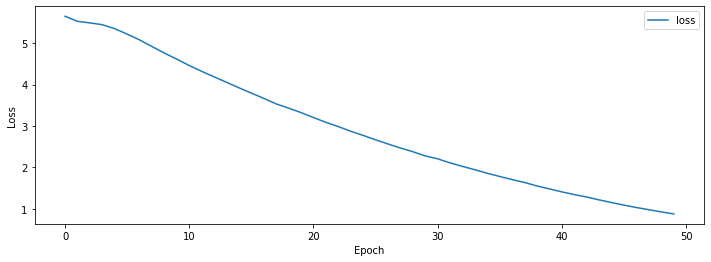

In [23]:
# 훈련이 진행되는 과정에 따라 loss를 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=[12, 4])
plt.plot(losses, label="loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 5. 테스트



#### 테스트 함수 작성

In [ ]:
# 7. 새로운 문장 테스트
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = WellnessTextClassificationDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids) # forward pass: compute predicted outputs by passing inputs to the model

        test_eval=[]
        for i in out:
            logits = i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("기쁨이")
            elif np.argmax(logits) == 1:
                test_eval.append("당황이")
            elif np.argmax(logits) == 2:
                test_eval.append("분노가")
            elif np.argmax(logits) == 3:
                test_eval.append("불안이")
            elif np.argmax(logits) == 4:
                test_eval.append("상처가")
            elif np.argmax(logits) == 5:
                test_eval.append("슬픔이")
            elif np.argmax(logits) == 6:
                test_eval.append("중립이")

        print(">> 입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")

####테스트 실행

In [ ]:
#질문 무한반복하기! 0 입력시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == 0 :
        break
    predict(sentence)
    print("\n")